 <a id="0"></a> <br>
**Содержание** 
1. [Предобработка данных](#1)
1. [Предварительная оценка эффективности акций](#2)
1. [Анализ эффективности акций (t-test)](#3) 
1. [Результат в виде саммари-таблиц](#4) 
1. [Общий вывод](#5)

**Условие задачи:**

Компания «ИП Иванов» является партнером программы лояльности Спасибо. Базовые условия сотрудничества для партнера: 
*	Начисление участникам программы лояльности 3% от суммы покупки в виде бонусов;
*	Участники программы могут списывать у партнера свои накопленные бонусы.

*Начисление баллов осуществляется только на часть чека, которую партнер оплатил рублями.*

Партнер проводил две акции на привлечение клиентов в период 03.12.2019-03.01.2020.
1.	Повышенное начисление 7% на первую покупку для клиентов из сегмента «Новые» – клиенты без покупок у партнера 6 и более месяцев
2.	Повышенное начисление 6% на первую покупку для клиентов из сегмента «Отток» - клиенты без покупки у партнера от 3 до 6 месяцев, но ранее совершали покупки у партнера.
<a id="12"></a> <br>
Для каждой акции подготовлена целевая и контрольная группы. На целевую группу высылается коммуникация о старте акции. Контрольная группа без коммуникации, предназначена для выделения эффектов акции при анализе. Количество клиентов в каждой группе ниже:
* 1.1.	Целевая 7% на Новых: 459939 участников
* 1.2.	Контрольная 7% на Новых: 51100 участников
* 2.1. Целевая 6% на Отток: 32224 участников
* 2.2. Контрольная 6% на Отток: 3576 участников

Прилагаются данные по транзакционной активности в период акции.
Перечень метрик и атрибутов:
* datetime – дата свершения транзакции
* promo – идентификатор акции
* control_group_flg – маркер контрольной группы
* customer_id – идентификатор клиента
* transaction_id – идентификатор свершенной транзакции
* transaction_amt – оборот по транзакции (рубли + бонусы)
* monetary_amt – оборот по транзакции (рубли)
* bonus_turn_amt – сумма начисленных бонусов по транзакции

**Задание:**

Провести анализ акции на основании сравнения целевой и контрольной группы. Оценить эффективность акции. Проанализировать ключевые метрики. При наличии положительного эффекта посчитать дополнительный оборот от акции для партнера. Покажите результат в виде саммари-таблицы.

**Примечание:**

Сохраняйте все промежуточные расчеты в файле. Оставляйте комментарии, если необходимо.


<a id="1"></a> <br>
***
# Предобратока данных

Импортируем библиотки:

In [1]:
# библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

#добавим констатну
RANDOM_STATE=42

* Верcия pandas: 1.2.4
* Верcия numpy: 1.23.5
* Верcия matplotlib.pyplot: 3.3.4
* Верcия scipy: 1.10.0

In [2]:
# выполним проверку на ошибку методом try-except
try:
    data = pd.read_excel('/Users/roman/Desktop/Data Scientist/Тестовые задания/Сбербанк/hw_1_dataset.xlsx')
# если при выгрузке таблицы что-то пойдёт не так, получим уведомление 
except:
    print('Что-то пошло не так.')

In [3]:
# методом .head() выведем заданое кол-во строк датафрейма
# методом .sort_values() отсорируем его по возрастанию даты
data = data.sort_values(by='datetime', ascending=True)
data.head(10)

,datetime,promo,control_group_flg,customer_id,transaction_id,transaction_amt,monetary_amt,bonus_turn_amt
17286,2019-12-03 05:41:18,Целевая 7% на Новых,False,311639887,103879482293,166.681543,166.681543,11.667708
17888,2019-12-03 07:14:26,Целевая 7% на Новых,False,218637813,103883590625,224.596317,224.596317,15.721742
13858,2019-12-03 07:33:10,Контрольная 7% на Новых,True,231041972,103884463400,696.050824,348.562183,10.452910
17375,2019-12-03 07:55:38,Целевая 7% на Новых,False,212985746,103885074544,46.331819,46.331819,3.234752
16156,2019-12-03 07:58:40,Целевая 7% на Новых,False,215002763,103885116418,563.609625,282.511090,19.775776
4727,2019-12-03 07:59:13,Целевая 7% на Новых,False,233849658,103885149646,177.981987,177.981987,12.458739
12569,2019-12-03 08:03:50,Целевая 7% на Новых,False,213702610,103885188033,182.219653,91.816104,6.427127
10236,2019-12-03 08:04:20,Контрольная 7% на Новых,True,214604834,103885197465,13.984299,13.984299,0.423767
21991,2019-12-03 08:10:20,Целевая 7% на Новых,False,215065230,103885292491,81.928216,81.928216,5.734975
19843,2019-12-03 08:11:14,Целевая 7% на Новых,False,217838093,103885323471,139.842990,139.842990,9.789009


Дубликаты отсутствуют:

In [4]:
# функция .duplicated() используется для поиска повторяющихся значений
# c помощью агрегирующей функции .sum() выведем сумму найденных дубликатов
data.duplicated().sum()

0

Посмотрим информацию о датафрейме:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23134 entries, 17286 to 11541
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   datetime           23134 non-null  datetime64[ns]
 1   promo              23134 non-null  object        
 2   control_group_flg  23134 non-null  bool          
 3   customer_id        23134 non-null  int64         
 4   transaction_id     23134 non-null  int64         
 5   transaction_amt    23134 non-null  float64       
 6   monetary_amt       23134 non-null  float64       
 7   bonus_turn_amt     23134 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 1.4+ MB


**Выводы:**

Мы имеет датасет в котором:
* 23134 значений весом 1.8+ MB;
* все столбцы имеют корретный тип данных;
* все столбцы приведены к единому змеиному_регистру;
* пропусуки в данных отсутствуют.

Добавим новые признаки для лучшей оценки эффективности:

In [6]:
# добавим новый признак, который будет содержать кол-во потраченых бонусов за транзацкию
data['bonus_amt'] = data['transaction_amt'] - data['monetary_amt']

In [7]:
# добавим новый признак, который покажет какой процент от покупки составляли бонус
data['bonus_percentage'] = (data['bonus_amt'] / data['transaction_amt']).round(2)

Используем метод `.describe()` для быстрого анализа описательной статистики числовых данных в DataFrame. Он возвращает сводку со следующими статистическими показателями для каждого числового столбца.

In [8]:
data.describe()

,customer_id,transaction_id,transaction_amt,monetary_amt,bonus_turn_amt,bonus_amt,bonus_percentage
count,2.313400e+04,2.313400e+04,23134.000000,23134.000000,23134.000000,23134.000000,23125.000000
mean,2.310358e+08,1.055184e+11,665.566046,457.533739,26.635838,208.032307,0.267917
std,2.728569e+07,9.352408e+08,1100.256485,917.749191,56.831020,350.192356,0.236776
min,2.022568e+08,1.038795e+11,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.133714e+08,1.047570e+11,125.717435,91.109827,4.845065,0.000000,0.000000
50%,2.208538e+08,1.054848e+11,348.971824,223.155510,12.077349,72.040328,0.390000
75%,2.396342e+08,1.063006e+11,832.807380,514.170184,29.289337,284.965405,0.500000
max,4.504294e+08,1.070389e+11,84372.389133,84372.389133,5062.344478,7119.279475,0.510000


<a id="8"></a> <br>
**Вывод:**

Видим, что есть транзакции с нулевым значением. В остальном данные выглядят корркетно, рассмотрим их детальнее чуть ниже.

Посчитаем количество транзакции с нулевым значением:

In [9]:
print('Количество транзакций с нулевым значением:')
print(data.query('transaction_amt == 0')['transaction_amt'].count())

Количество транзакций с нулевым значением:
9


Избавимся от аномальных транзакций с нуловой стоимостью.

In [10]:
# методом .query() отфильтруем датафрейм
data = data.query('transaction_amt > 0')

In [11]:
# методом .shape выведем размер датафрейма
data.shape

(23125, 10)

<a id="10"></a> <br>
Разобьем данные на 2 акции по 2 выборки в каждой - целевую и контрольную:

In [12]:
# отфильтруем датафрейм по заданным значеням
new = data.query("`promo`.str.contains('7')")
new_target = new.query('control_group_flg == False').reset_index(drop=True)
new_control = new.query('control_group_flg == True').reset_index(drop=True)
new_target.head(5)

,datetime,promo,control_group_flg,customer_id,transaction_id,transaction_amt,monetary_amt,bonus_turn_amt,bonus_amt,bonus_percentage
0,2019-12-03 05:41:18,Целевая 7% на Новых,False,311639887,103879482293,166.681543,166.681543,11.667708,0.000000,0.0
1,2019-12-03 07:14:26,Целевая 7% на Новых,False,218637813,103883590625,224.596317,224.596317,15.721742,0.000000,0.0
2,2019-12-03 07:55:38,Целевая 7% на Новых,False,212985746,103885074544,46.331819,46.331819,3.234752,0.000000,0.0
3,2019-12-03 07:58:40,Целевая 7% на Новых,False,215002763,103885116418,563.609625,282.511090,19.775776,281.098535,0.5
4,2019-12-03 07:59:13,Целевая 7% на Новых,False,233849658,103885149646,177.981987,177.981987,12.458739,0.000000,0.0


In [13]:
outflow = data.query("`promo`.str.contains('6')")
outflow_target = outflow.query('control_group_flg == False').reset_index(drop=True)
outflow_control = outflow.query('control_group_flg == True').reset_index(drop=True)
outflow_control.head(5)

,datetime,promo,control_group_flg,customer_id,transaction_id,transaction_amt,monetary_amt,bonus_turn_amt,bonus_amt,bonus_percentage
0,2019-12-03 09:01:06,Контрольная 6% на Отток,True,213644935,103886219495,24.013443,24.013443,0.720403,0.00000,0.0
1,2019-12-03 09:24:37,Контрольная 6% на Отток,True,213450097,103887319482,1002.801366,502.756736,15.086092,500.04463,0.5
2,2019-12-03 09:32:38,Контрольная 6% на Отток,True,238327644,103887748723,99.302648,99.302648,2.980492,0.00000,0.0
3,2019-12-03 10:12:02,Контрольная 6% на Отток,True,212772882,103890797431,2107.532734,2107.532734,63.225982,0.00000,0.0
4,2019-12-03 10:12:54,Контрольная 6% на Отток,True,212772882,103890914129,42.376664,42.376664,1.271300,0.00000,0.0


Удалим лишние столбцы, которые более не понадобятся в нашем исследовании:

In [14]:
# список DataFrame, из которых нужно удалить столбец
dataframes = [new_target, new_control, outflow_target, outflow_control]

# цикл для удаления столбца control_group_flg из каждого DataFrame
for df in dataframes:
    df.drop(columns=['control_group_flg', 'promo'], axis=1, inplace=True)

Сравним выборки и приведем их в размерный баланс.

Для акции новых клиентов:

In [15]:
print('Целевая группа для новых клиентов:') 
print(new_target.shape[0])
print('Контрольная для новых клиентов:')
print(new_control.shape[0])

Целевая группа для новых клиентов:
16295
Контрольная для новых клиентов:
1775


In [16]:
# извлекаем случайное подмножество из целевой группы
# значение replace=False в методе sample указывает, что выборка элементов
# из outflow_target выполняется без повторений, то есть каждый элемент может быть выбран только один раз.
new_target_sampled = new_target.sample(n=len(new_control),
                                       replace=False,
                                       random_state=RANDOM_STATE)

# выводим результаты
print('Целевая группа (уровненная) для новых клиентов::')
print(new_target_sampled.shape[0])
print('Контрольная группа для новых клиентов:')
print(new_control.shape[0])

Целевая группа (уровненная) для новых клиентов::
1775
Контрольная группа для новых клиентов:
1775


**Вывод по разделу:**

Мы подготовили и уровняли две выборки для t-теста. Эта функция используется для сравнения средних значений двух выборок и определения, есть ли статистически значимая разница между ними.

Для максимальной объективности t-теста нам пришлось уровнять выборки по наименьшей, при этом потеряв около 85% значений целевой группы. 

**Рекомендация:**

По возможности, нам стоит обратиться к заказчику, чтобы постараться увеличить размер контрольной группы для увеличения точности оценки эффективности акций.

Аналогично для акции "оттока":

In [17]:
print('Целевая группа для оттока:') 
print(outflow_target.shape[0])
print('Контрольная для оттока клиентов:')
print(outflow_control.shape[0])

Целевая группа для оттока:
4622
Контрольная для оттока клиентов:
433


In [18]:
outflow_target_sampled = outflow_target.sample(n=len(outflow_control),
                                               replace=False,
                                               random_state=RANDOM_STATE)

print('Целевая группа (уровненная) для старых клиентов:')
print(outflow_target_sampled.shape[0])
print('Контрольная группа для новых клиентов:')
print(outflow_control.shape[0])

Целевая группа (уровненная) для старых клиентов:
433
Контрольная группа для новых клиентов:
433


**Вывод:**

На данном этапе мы изучили и обработали наш датафрейм - избавились от аномалий. Далее мы разбили его на 4 ключевых группы (2 акции по 2 группы - целевые и контрольные) и привели смежные группы к размерному балансу для дальншенего анализа и проведения t-теста.

Размер датасета для новый клиентов: 
1775


Размер датасета для старых клиентов: 
433

<a id="2"></a> <br>
***
# Предварительная оценка эффективности акций

Проведём анализ акций на основании сравнения целевой и контрольной группы. Напомним описание столбцов:

* `datetime` – дата свершения транзакции
* `promo` – идентификатор акции
* `control_group_flg` – маркер контрольной группы
* `customer_id` – идентификатор клиента
* `transaction_id` – идентификатор свершенной транзакции
* `transaction_amt` – оборот по транзакции (рубли + бонусы)
* `bonus_amt` - оборот по тразнакциям (бонусы)
* `monetary_amt` – оборот по транзакции (рубли)
* `bonus_turn_amt` – сумма начисленных бонусов по транзакции
* `bonus_percentage` - доля бонусов в транзакции (от 0 до 0.5)

***
**Для новых клиентов:**

Используем метод `.describe()` для анализа полученных групп:

Для новых клиентов целевой группы:

In [19]:
new_target_sampled[['transaction_amt',
                    'bonus_amt',
                    'monetary_amt',
                    'bonus_turn_amt',
                    'bonus_percentage']].describe()

,transaction_amt,bonus_amt,monetary_amt,bonus_turn_amt,bonus_percentage
count,1775.000000,1775.000000,1775.000000,1775.000000,1775.000000
mean,658.055271,210.411889,447.643383,28.227545,0.265656
std,979.530428,365.010713,736.295466,49.534490,0.237600
min,2.825111,0.000000,2.825111,0.127130,0.000000
25%,125.717435,0.000000,91.816104,5.636096,0.000000
50%,344.663530,69.780239,224.596317,13.094389,0.370000
75%,816.457051,284.361538,510.921307,31.605928,0.500000
max,15326.226648,4350.670790,13512.505449,945.875381,0.500000


Для новых клиентов контрольной группы:

In [20]:
new_control[['transaction_amt',
             'bonus_amt',
             'monetary_amt',
             'bonus_turn_amt',
             'bonus_percentage']].describe()

,transaction_amt,bonus_amt,monetary_amt,bonus_turn_amt,bonus_percentage
count,1775.000000,1775.000000,1775.000000,1775.000000,1775.000000
mean,638.001472,208.840729,429.160743,12.875351,0.262930
std,991.124677,364.383968,733.091651,21.992639,0.239835
min,2.825111,0.000000,2.825111,0.084753,0.000000
25%,122.892324,0.000000,90.050410,2.697981,0.000000
50%,351.726307,67.802662,226.856406,6.808517,0.380000
75%,801.512214,307.866461,480.268853,14.408066,0.500000
max,18443.454019,6555.415590,11888.038428,356.642000,0.500000


**Вывод:**

Оценим показатели по средним значениям - `mean`:

`bonus_turn_amt` - сумма начисленных бонусов по транзакции. Одназначно можно утверждать, что как минимум в 2 раза выросло количество начисляемых бонусов, что логично, учитывая особенность акции. Остальные показатели отличаются незначительно и требуют более глубокого статистического анализа - `t-теста`.

Сравним другие показатели, которых нет в методе `.describe()`:

In [21]:
# методом .pivot_table() создадим сводную таблицу
# в которой параметром aggfunc='count' выведем 
# количество value - transaction_id по index - customer_id.
new_target_customer = new_target_sampled.pivot_table(index='customer_id',
                                    values='transaction_id',
                                    aggfunc='count')
new_target_customer = new_target_customer.rename(columns={'transaction_id': 'count'})


new_control_customer = new_control.pivot_table(index='customer_id',
                                    values='transaction_id',
                                    aggfunc='count')
# переименуем столбец сводной таблицы
new_control_customer = new_control_customer.rename(columns={'transaction_id': 'count'})

# сравним результаты
print('Среднее количество покупок на нового клиента целевой группы:')
print(new_target_customer['count'].mean().round(3))
print('Среднее количество покупок на нового клиента контрольной группы:')
print(new_control_customer['count'].mean().round(3))

Среднее количество покупок на нового клиента целевой группы:
1.033
Среднее количество покупок на нового клиента контрольной группы:
1.204


**Вывод:**

Предварительно, можно сделать вывод о том, что клиенты целевой группы совершали **в среднем на 16.62% покупок меньше**, чем в контрольной группе. Это может объясняется тем, что выбор целевой группы пал на более дорогие вещи, однако сократив при этом их численность.

In [22]:
new_target_mean = new_target_sampled.pivot_table(index='customer_id',
                                    values='monetary_amt',
                                    aggfunc='mean')
new_target_mean = new_target_mean.rename(columns={'monetary_amt': 'mean'})


new_control_mean = new_control.pivot_table(index='customer_id',
                                    values='monetary_amt',
                                    aggfunc='mean')
new_control_mean = new_control_mean.rename(columns={'monetary_amt': 'mean'})

print('Средний оборот (рубли) нового клиента целевой группы:')
print(new_target_mean['mean'].mean().round(2))
print('Средний оборот (рубли) нового клиента контрольной группы:')
print(new_control_mean['mean'].mean().round(2))

Средний оборот (рубли) нового клиента целевой группы:
446.89
Средний оборот (рубли) нового клиента контрольной группы:
425.39


**Вывод:**

Предварительно, можно сделать вывод о том, что клиенты целевой группы совершали покупки товаров, которые **в среднем на 4.81% дороже**, чем у клиентов контрольной группы, что потверждает выдвинутое выше предположение.

In [23]:
new_target_sum = new_target_sampled.pivot_table(index='customer_id',
                                    values='monetary_amt',
                                    aggfunc='sum')
new_target_sum = new_target_sum.rename(columns={'monetary_amt': 'sum'})


new_control_sum = new_control.pivot_table(index='customer_id',
                                    values='monetary_amt',
                                    aggfunc='sum')
new_control_sum = new_control_sum.rename(columns={'monetary_amt': 'sum'})

print('Сумма оборота (рубли) новых клиентов целевой группы:')
print(new_target_sum['sum'].sum().round(2))
print('Сумма оборота (рубли) новых клиентов контрольной группы:')
print(new_control_sum['sum'].sum().round(2))

Сумма оборота (рубли) новых клиентов целевой группы:
794567.0
Сумма оборота (рубли) новых клиентов контрольной группы:
761760.32


**Вывод:**

Предварительно, можно сделать вывод о том, что клиенты целевой группы в совокупности **потратили на 4.13% больше**, чем клиенты контрольной группы. Можно предположить, что акция дала эффект - увеличила траты клиентов, однако, в этом ещё предстоить убедиться в проведя статистический тест.



***
**Для старых клиентов:**

Для старых клиентов целевой группы:

In [24]:
outflow_target_sampled[['transaction_amt',
                        'bonus_amt',
                        'monetary_amt',
                        'bonus_turn_amt',
                        'bonus_percentage']].describe()

,transaction_amt,bonus_amt,monetary_amt,bonus_turn_amt,bonus_percentage
count,433.000000,433.000000,433.000000,433.000000,433.000000
mean,670.807969,215.060360,455.747609,24.156884,0.280439
std,923.909474,356.328326,655.347844,37.653314,0.233493
min,12.712999,0.000000,12.712999,0.423767,0.000000
25%,141.255545,0.000000,103.116548,5.000446,0.000000
50%,363.733029,87.295927,237.662455,11.780712,0.450000
75%,832.023412,293.811534,513.322651,27.460078,0.500000
max,8217.258828,2757.308241,6088.113996,365.286840,0.500000


<a id="6"></a> <br>
Для старых клиентов контрольной группы:

In [25]:
outflow_control[['transaction_amt',
                 'bonus_amt',
                 'monetary_amt',
                 'bonus_turn_amt',
                 'bonus_percentage']].describe()

,transaction_amt,bonus_amt,monetary_amt,bonus_turn_amt,bonus_percentage
count,433.000000,433.000000,433.000000,433.000000,433.000000
mean,644.367117,177.126624,467.240492,14.017770,0.263441
std,821.632856,254.327781,691.376668,20.741396,0.236020
min,2.825111,0.000000,2.825111,0.084753,0.000000
25%,156.793655,0.000000,108.908025,3.263003,0.000000
50%,351.726307,81.928216,243.242049,7.302912,0.360000
75%,849.228337,271.210647,538.183627,16.145509,0.500000
max,6633.360400,1644.511182,5464.470764,163.941186,0.500000


**Вывод:**

Оценим показатели по средним значениям - `mean`:

`bonus_amt` - оборот по тразнакциям (бонусы). Из таблицы можно предположить, что на в 21.4% вырос оборот по бонусам.

Сравним другие показатели, которых нет в методе `.describe()`:

In [26]:
outflow_target_customer = outflow_target_sampled.pivot_table(index='customer_id',
                                    values='transaction_id',
                                    aggfunc='count')
outflow_target_customer = outflow_target_customer.rename(columns={'transaction_id': 'count'})


outflow_control_customer = outflow_control.pivot_table(index='customer_id',
                                    values='transaction_id',
                                    aggfunc='count')
outflow_control_customer = outflow_control_customer.rename(columns={'transaction_id': 'count'})

print('Среднее количество покупок на старого клиента целевой группы:')
print(outflow_target_customer['count'].mean().round(3))
print('Среднее количество покупок на старого клиента контрольной группы:')
print(outflow_control_customer['count'].mean().round(3))

Среднее количество покупок на старого клиента целевой группы:
1.036
Среднее количество покупок на старого клиента контрольной группы:
1.266


**Вывод:**

Предварительно, можно сделать вывод о том, что клиенты целевой группы совершали **в среднем на 22.2% покупок меньше**, чем в контрольной группе. Это может объясняется тем, что выбор целевой группы пал на более дорогие вещи, однако сократив при этом их численность.

In [27]:
outflow_target_mean = outflow_target_sampled.pivot_table(index='customer_id',
                                    values='monetary_amt',
                                    aggfunc='mean')
outflow_target_mean = outflow_target_mean.rename(columns={'monetary_amt': 'mean'})


outflow_control_mean = outflow_control.pivot_table(index='customer_id',
                                    values='monetary_amt',
                                    aggfunc='mean')
outflow_control_mean = outflow_control_mean.rename(columns={'monetary_amt': 'mean'})

print('Средняя сумма покупки (рубли) старого клиента целевой группы:')
print(outflow_target_mean['mean'].mean().round(2))
print('Средняя сумма покупки (рубли) старого клиента контрольной группы:')
print(outflow_control_mean['mean'].mean().round(2))

Средняя сумма покупки (рубли) старого клиента целевой группы:
454.08
Средняя сумма покупки (рубли) старого клиента контрольной группы:
473.02


**Вывод:**

Предварительно, можно сделать вывод о том, что клиенты целевой группы совершали покупки товаров, которые **в среднем на 4.17% дешевле**, чем у клиентов контрольной группы, **что опровергает выдвинутое выше предположение.**

In [28]:
outflow_target_sum = outflow_target_sampled.pivot_table(index='customer_id',
                                    values='monetary_amt',
                                    aggfunc='sum')
outflow_target_sum = outflow_target_sum.rename(columns={'monetary_amt': 'sum'})


outflow_control_sum = outflow_control.pivot_table(index='customer_id',
                                    values='monetary_amt',
                                    aggfunc='sum')
outflow_control_sum = outflow_control_sum.rename(columns={'monetary_amt': 'sum'})

print('Сумма покупок (рубли) старых клиентов целевой группы:')
print(outflow_target_sum['sum'].sum().round(2))
print('Сумма покупок (рубли) старых клиентов контрольной группы:')
print(outflow_control_sum['sum'].sum().round(2))

Сумма покупок (рубли) старых клиентов целевой группы:
197338.71
Сумма покупок (рубли) старых клиентов контрольной группы:
202315.13


**Вывод:**

Предварительно, можно сделать вывод о том, что клиенты целевой группы в совокупности **потратили на 2.52% меньше**, чем клиенты контрольной группы. Можно предположить, что акция дала обратный эффект - уменьшила траты клиентов и количество их покупок. Однако, можно заключить, что **акция неэффективна**.


**Вывод по разделу:**

Предварительная оценка акций позволила нам сделать следующие выводы:
* акция для новых клиетов оказалось **эффективной** - покупок **меньше на 16.62%**, но в среднем их стоимость **выше на 4.81%**, и в совокупности они принесли прибыли в рублях **больше на 4.13%**;
* акция для старых клиенов оказалось **неэффективна** - покупок **меньше на 22.22%** и в среднем их стоимость **ниже на 4.17%**, и в совокупности они принесли прибыли в рублях **меньше на 2.52%**.

<a id="3"></a> <br>
***
# Анализ эффективности акций (t-test)

Для оценки эффективности возьмем метрики, которые ранее показали значительные положительные изменения.

***
**Акция для клиентов из сегмента «Новые»**

Выполненим двусторонний t-теста на независимых выборках. Эта функция используется для сравнения средних значений двух выборок и определения, есть ли статистически значимая разница между ними.

**Проверим метрику`Средний оборот (рубли) на клиента`:**

In [29]:
print('Средний оборот (рубли) нового клиента целевой группы:')
print(new_target_mean['mean'].mean().round(2))
print('Средний оборот (рубли) нового клиента контрольной группы:')
print(new_control_mean['mean'].mean().round(2))

Средний оборот (рубли) нового клиента целевой группы:
446.89
Средний оборот (рубли) нового клиента контрольной группы:
425.39


Предположим что это могло произойти случайно. Пусть нулевая гипотеза звучит так - средний оборот (рубли) на одного клиента целевой и контрольной групп равны. Альтернативная - не равны.

In [30]:
# установим уровень доверия чуть выше стандартного - 0.06, равный единице минус уровень значимости
alpha = 0.06

results = st.ttest_ind(new_target_mean['mean'], new_control_mean['mean'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.3960429735792196
Не получилось отвергнуть нулевую гипотезу


**Вывод:**

**С вероятностью 39.6 % различие можно было получить случайно**. Это значит, что вероятнее всего сумма оборота (рубли) целевой и контрольной групп не отличается

**Проверим метрику `Среднее количество покупок на одного клиента`:**

In [31]:
print('Среднее количество покупок на нового клиента целевой группы:')
print(new_target_customer['count'].mean().round(3))
print('Среднее количество покупок на нового клиента контрольной группы:')
print(new_control_customer['count'].mean().round(3))

Среднее количество покупок на нового клиента целевой группы:
1.033
Среднее количество покупок на нового клиента контрольной группы:
1.204


Предположим что это могло произойти случайно. Пусть нулевая гипотеза звучит так - среднее количество покупок на клиента равное. Альтернативная - не равное.

In [32]:
results = st.ttest_ind(new_target_customer['count'], new_control_customer['count'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.8718055584632767e-32
Отвергаем нулевую гипотезу


**Выводы:**

Отвеграем нулевую гипотезу, следовательно **количество покупок уменьшилось из-за акции**.

<a id="7"></a> <br>
**Возьмем `Сумма оборота (рубли) новых клиентов` за ключевую метрику:**

In [33]:
print('Сумма оборота (рубли) новых клиентов целевой группы:')
print(new_target_sum['sum'].sum().round(2))
print('Сумма оборота (рубли) новых клиентов контрольной группы:')
print(new_control_sum['sum'].sum().round(2))

Сумма оборота (рубли) новых клиентов целевой группы:
794567.0
Сумма оборота (рубли) новых клиентов контрольной группы:
761760.32


Предположим что это могло произойти случайно. Пусть нулевая гипотеза звучит так - сумма оборота (рубли) новых клиентов целевой и контрольной групп равна. Альтернативная - не равна.

In [34]:
results = st.ttest_ind(new_target_sum['sum'], new_control_sum['sum'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.05694597705859967
Отвергаем нулевую гипотезу


**Выводы:**

Отвеграем нулевую гипотезу, следовательно `ключевая метрика` - **сумма оборота в рублях увеличилась из-за акции**.

***
**Акция для клиентов из сегмента «Отток»**

Акция для старых клиентов показала себя неэффективной на этапе предворительной оценки, поэтому проводить t-test нецелесообразно в рамках нашей задачи. Однако интересно проверить гипотезу о том, что данная акция повлияла на увелечение `bonus_amt` - оборот по транзакции (бонусы).

**Проверим гипотезу. Возьмем за ключевую метрику `bonus_amt` - оборот по транзакции (бонусы) за ключевую метрику, поскольку при сравнительном анализе [выше](#6) методом `.describe()` была заметна их разница.**

In [35]:
print('Средний оборот для целевой группы по транзакции (бонусы):')
print(outflow_target_sampled['bonus_amt'].mean().round(2))
print('Средний оборот для контрольной группы по транзакции (бонусы):')
print(outflow_control['bonus_amt'].mean().round(2))

Средний оборот для целевой группы по транзакции (бонусы):
215.06
Средний оборот для контрольной группы по транзакции (бонусы):
177.13


Предположим что это могло произойти случайно. Пусть нулевая гипотеза звучит так - средний оборот равен. Альтернативная - не равен.

In [36]:
results = st.ttest_ind(outflow_target_sampled['bonus_amt'], outflow_control['bonus_amt'])

print('p-значение:', results.pvalue.round(3))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.072
Не получилось отвергнуть нулевую гипотезу


**Вывод:**

С вероятностью 7.2 % различие можно было получить случайно. Это значит, что вероятнее всего средний оборот по транзакции (бонусы) целевой и контрольной выборок не отличается.

**Вывод по разделу:**

Акция для новых клиентов **доказала свою эффективность** с помощью [статистического теста](#7), который подвердил, что увеличение ключевой метрики - `суммы оборота в рублях` **получено неслучайно**.

<a id="4"></a> <br>
***
# Результат в виде саммари-таблиц:

Создадим саммари-таблицы по итогам двух акций для наглядности результатов:

***
**Саммари-таблица для новых клиентов:**

In [37]:
# посчитаем разницу в процентах между целевой и контрольной группой
# для количества покупок
dif_new_1 = (((new_target_customer['count'].mean() 
                   - new_control_customer['count'].mean())/
                    new_target_customer['count'].mean()) * 100).round(2) 
# для средней суммы покупок
dif_new_2 = (((new_target_mean['mean'].mean() 
                   - new_control_mean['mean'].mean())/
                    new_target_mean['mean'].mean()) * 100).round(2)
# для суммы покупок
dif_new_3 = (((new_target_sum['sum'].sum() 
                   - new_control_sum['sum'].sum())/
                    new_target_sum['sum'].sum()) * 100).round(2)

# Создание словаря для сводной таблицы
new_summary_data = {
    'категория': ['целевая',
                'контрольная',
                'разница (процент_%)',
                'статистически_значимая_разница'],
    'среднее_количество_покупок_клиента': [new_target_customer['count'].mean().round(3),
                                           new_control_customer['count'].mean().round(3),
                                           dif_new_1,
                                           'да'],
    'средний_оборот_нового_клиента': [new_target_mean['mean'].mean().round(2),
                                      new_control_mean['mean'].mean().round(2),
                                      dif_new_2,
                                      'нет'],
    'сумма_оборота_новых_клиентов': [new_target_sum['sum'].sum().round(1),
                                     new_control_sum['sum'].sum().round(1),
                                     dif_new_3,
                                     'да']
}

# cоздание сводной таблицы
new_summary_table = pd.DataFrame(new_summary_data)

# результат таблицы ниже - для удобства сопоставления с таблицей

***
**Саммари-таблица для старых клиентов:**

In [38]:
dif_outflow_1 = (((outflow_target_customer['count'].mean() 
                   - outflow_control_customer['count'].mean())/
                    outflow_target_customer['count'].mean()) * 100).round(2) 

dif_outflow_2 = (((outflow_target_mean['mean'].mean() 
                   - outflow_control_mean['mean'].mean())/
                    outflow_target_mean['mean'].mean()) * 100).round(2)

dif_outflow_3 = (((outflow_target_sum['sum'].sum() 
                   - outflow_control_sum['sum'].sum())/
                    outflow_target_sum['sum'].sum()) * 100).round(2)


outflow_summary_data = {
    'категория': ['целевая',
                'контрольная',
                'разница (процент_%)'],
    'среднее_количество_покупок_клиента': [outflow_target_customer['count'].mean().round(3),
                                           outflow_control_customer['count'].mean().round(3),
                                           dif_outflow_1],
    'средний_оборот_старого_клиента': [outflow_target_mean['mean'].mean().round(2),
                                      outflow_control_mean['mean'].mean().round(2),
                                      dif_outflow_2],
    'сумма_оборота_старых_клиентов': [outflow_target_sum['sum'].sum().round(1),
                                     outflow_control_sum['sum'].sum().round(1),
                                     dif_outflow_3]
}

outflow_summary_table = pd.DataFrame(outflow_summary_data)

# результат таблицы так же ниже - для удобства сопоставления с таблицей

***
**Мини-дашборды по новым клиентам:**

Создадим мини-дашборд для визуализации результатов эффективной акции:

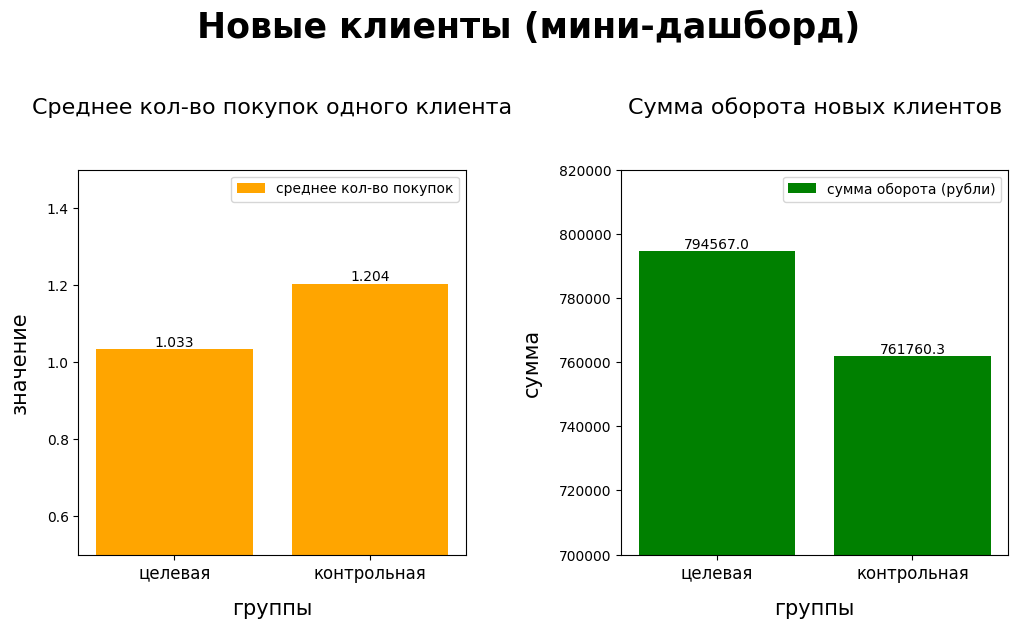

In [44]:
# отфильтруем нужные строки
new_summary_table_filter = new_summary_table.head(2)
# создаём области для мини-дашборда размером 1 на 2
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# задаем расстояние между графиками по оси х
fig.subplots_adjust(wspace=0.4)
# заголовок для мини-дашборда
fig.suptitle('Новые клиенты (мини-дашборд)',
             fontsize=25,
             fontweight='bold',
             y=1.2)
# график 1 - координаты [0] указывает на размещение
# первого графика в левой части
ax[0].bar(new_summary_table_filter['категория'],
             new_summary_table_filter['среднее_количество_покупок_клиента'],
# задаем цвет графика
             color='orange',
# подписываем легенду
             label='среднее кол-во покупок')
# устанавливаем заголовок графика
# параметром pad задаём отступ от графика
ax[0].set_title('Среднее кол-во покупок одного клиента',
                   fontsize=16, pad=40)
# задаем наклон надписей
ax[0].tick_params(axis='x', rotation=0, labelsize=12)
# устанавливаем подпись по оси x
# параметром fontsize задаём размер
# параметром labelpad задаём отсуп надписи от оси
ax[0].set_xlabel('группы', fontsize=15, labelpad=12)
ax[0].set_ylabel('значение', fontsize=15, labelpad=12)
# устанавливаем диапазон отображаемых значений по оси y
ax[0].set_ylim(0.5, 1.5)
# мы используем цикл for для перебора индексов и значений столбца "количество",
# затем мы используем метод .annotate() для добавления каждого значения на график.
# аргументы метода annotate определяют, что отображать на графике и где его разместить.
for i, value in enumerate(new_summary_table_filter['среднее_количество_покупок_клиента']):
    ax[0].annotate(str(value), (i, value), ha='center', va='bottom')
ax[0].legend()    
    
# график 2
ax[1].bar(new_summary_table_filter['категория'],
             new_summary_table_filter['сумма_оборота_новых_клиентов'],
             color='green',
             label='сумма оборота (рубли)')
ax[1].set_title('Сумма оборота новых клиентов',
                   fontsize=16, pad=40)
ax[1].tick_params(axis='x', rotation=0, labelsize=12)
ax[1].set_xlabel('группы', fontsize=15, labelpad=12)
ax[1].set_ylabel('сумма', fontsize=15, labelpad=12)
ax[1].set_ylim(700_000, 820_000)
for i, value in enumerate(new_summary_table_filter['сумма_оборота_новых_клиентов']):
    ax[1].annotate(str(value), (i, value), ha='center', va='bottom')
ax[1].legend()   

<a id="11"></a> <br>
**Самари-таблица акции для новых клиентов:**

In [40]:
new_summary_table

,категория,среднее_количество_покупок_клиента,средний_оборот_нового_клиента,сумма_оборота_новых_клиентов
0,целевая,1.033,446.89,794567.0
1,контрольная,1.204,425.39,761760.3
2,разница (процент_%),-16.62,4.81,4.13
3,статистически_значимая_разница,да,нет,да


**Вывод:**

Мы составили саммари-таблицу для **эффективной акции для новых клиентов** по важным метрикам и изменениям, включая ключевую - столбец `сумма_оборота_новых_клиентов`, а так же дополнили её результатами t-теста. Так же создали мини-дашборд для наглядности ключевых метрик, которые указывают на эффективность акции для новых клиентов.

Из таблицы видно, что после акции: покупок **меньше на 16.62%**, но в среднем их стоимость **выше на 4.81%**, и в совокупности они принесли прибыли в рублях **больше на 4.13% (ключевая метрика)**.

Так же стоит отметить одну особенность акции: клиенты стали делать меньше заказов, однако они стали дороже, что привело к увелечению прибыли в рублях.

***
**Самари-таблица акции для старых клиентов:**

In [41]:
outflow_summary_table

,категория,среднее_количество_покупок_клиента,средний_оборот_старого_клиента,сумма_оборота_старых_клиентов
0,целевая,1.036,454.08,197338.70
1,контрольная,1.266,473.02,202315.10
2,разница (процент_%),-22.220,-4.17,-2.52


**Вывод:**

Мы составили саммари-таблицу для **неэффективной акции для старых клиентов** по важным метрикам и изменениям, включая ключевую - столбец `сумма_оборота_новых_клиентов`. Т-тест не проводился, поскольку на этапе предварительной оценки не выявленно положительных изменений. 

Из таблицы видно, что после акции: покупок **меньше на 22.22%** и в среднем их стоимость **ниже на 4.17%**, и в совокупности они принесли прибыли в рублях **меньше на 2.52% (ключевая метрика)**.

**Вывод по разделу:**

Мы составили смарт-таблицы по двум акциям - для новых и старых клиентов, вывели их в одном зрительном поле для наглядности сравнения. Эффективную акцию дополнили визуализацией в виде мини-дашборода.

<a id="5"></a> <br>
***
# Общий вывод

**Общий вывод:**

1. Мы обработали датафрей и избавились от аномальных транзакций с нулевой [стоимостью](#8). Обогатили его двумя новыми признаками:
* `bonus_amt` - оборот по тразнакциям (бонусы);
* `bonus_percentage` - доля бонусов в транзакции (от 0 до 0.5).

2. Далее мы разбили его на [4 ключевых группы](#10) (2 акции по 2 группы - целевые и контрольные) и привели смежные группы к размерному балансу для дальншенего анализа и проведения t-теста.


3. Предварительная оценка [акций](#2) позволила нам сделать следующие выводы:
* акция для новых клиетов оказалось **эффективной** - покупок **меньше на 16.62%**, но в среднем их стоимость **выше на 4.81%**, и в совокупности они принесли прибыли в рублях **больше на 4.13%**;
* акция для старых клиенов оказалось **неэффективна** - покупок **меньше на 22.22%** и в среднем их стоимость **ниже на 4.17%**, и в совокупности они принесли прибыли в рублях **меньше на 2.52%**.

4. Провели статистический [тест](#7) на акции для новых клиентов, который подвердил, что увеличение ключевой метрики - `суммы оборота в рублях` **получено неслучайно**.


5. Для наглядности результата построили [саммари-таблицы](#11) и мини-дашборд.

**Предложения:**

Судя по [данным](#12), соотношение участников акции, которое было выбрано в данном случае, кажется некорректным. Разница в количестве участников между целевой группой (**459939 участников**) и контрольной группой (**51100 участников**) **отличается в 9 раз**.

Для достоверного проведения эксперимента на акции, рекомендуется выбирать более однородные группы участников, чтобы уменьшить влияние других факторов и получить достоверные результаты. Рекомендуется пересмотреть соотношение участников между группами и уравновесить их размеры для более точного контроля и оценки результатов акции.

Это поможет получить более надежные данные и корректно измерить эффективность акции. 